In [1]:
import os, warnings, random
from dataclasses import dataclass
from typing import Tuple, List, Optional, Literal
from contextlib import contextmanager

import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import spearmanr

def set_global_seed(seed: Optional[int]):
    if seed is None:
        return
    seed = int(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception:
        pass

@contextmanager
def numpy_seed(seed: Optional[int]):
    if seed is None:
        yield
        return
    state = np.random.get_state()
    np.random.seed(int(seed))
    try:
        yield
    finally:
        np.random.set_state(state)

def deterministic_sample(df: pd.DataFrame, n: int, seed: Optional[int]) -> pd.DataFrame:
    if df is None:
        return df
    n = min(n, len(df))
    if n == len(df):
        return df.copy()
    if seed is None:
        return df.iloc[:n].copy()
    return df.sample(n=n, random_state=int(seed), replace=False)


In [2]:
@dataclass
class PipelineConfig:
    data_path: str = "./../dataset/CM1.csv"
    target_col: str = "Defective"
    save_dir: str = "./outputs"
    protocol: Literal["kfold","repeated_holdout"] = "kfold"
    n_splits: int = 5
    repeats: int = 30
    holdout_test_size: float = 0.2
    rng: int = 42
    use_smote: bool = True
    smote_k_max: int = 5
    model: Literal["random_forest","xnam","lcnn1d","lcnn2d","all"] = "random_forest"
    importance_source: Literal["shap","gradient"] = "shap"
    shap_method: Literal["auto","tree","kernel"] = "auto"
    top_k: int = 10
    nam_hidden: Tuple[int,int] = (64, 32)
    nam_dropout: float = 0.1
    lcnn_channels: Tuple[int,int] = (32, 64)
    lcnn_kernel: int = 3
    batch_size: int = 128
    max_epochs: int = 30
    early_stop_patience: int = 5
    lr: float = 1e-3
    l2_weight: float = 0.0

In [3]:
def load_or_synthesize(cfg: PipelineConfig, allow_synthetic: bool = False):
    path = cfg.data_path
    tgt  = cfg.target_col

    if os.path.exists(path):
        df = pd.read_csv(path)
        for c in list(df.columns):
            if str(c).strip().lower().startswith("unnamed:"):
                df = df.drop(columns=[c])

        if tgt in df.columns:
            X = df.drop(columns=[tgt]).copy()
            y = df[tgt].astype(int).copy()
            print(f"Loaded dataset with header: {path}")
            print("Shape:", X.shape)
            print("Class distribution:", dict(pd.Series(y).value_counts()))
            return X, y

        df_try = pd.read_csv(path, header=None)
        hdr = df_try.iloc[0].astype(str).tolist()
        df2 = df_try.iloc[1:].copy()
        df2.columns = hdr
        for c in list(df2.columns):
            if str(c).strip().lower().startswith("unnamed:"):
                df2 = df2.drop(columns=[c])

        if tgt in df2.columns:
            X = df2.drop(columns=[tgt]).copy()
            y = df2[tgt].astype(int).copy()
            print(f"Loaded dataset (first row used as header): {path}")
            print("Shape:", X.shape)
            print("Class distribution:", dict(pd.Series(y).value_counts()))
            return X, y

        df3 = pd.read_csv(path, header=None)
        cols = [f"col_{i}" for i in range(df3.shape[1])]
        df3.columns = cols

        norm = lambda s: str(s).strip().lower()
        candidates = [c for c in df3.columns if norm(c) == norm(tgt)]
        if candidates:
            tgt_col = candidates[0]
            X = df3.drop(columns=[tgt_col]).copy()
            y = df3[tgt_col].astype(int).copy()
            print(f"Loaded dataset (headerless, matched target by name): {path}")
            print("Shape:", X.shape)
            print("Class distribution:", dict(pd.Series(y).value_counts()))
            return X, y

        raise ValueError(
            f"Could not find target column '{tgt}' in '{path}'. "
            "Please check the CSV header or provide the correct target_col."
        )

    if not allow_synthetic:
        raise FileNotFoundError(
            f"Dataset not found at '{path}'. Set allow_synthetic=True to generate a toy dataset, "
            "or fix DATA_PATH so we can preserve real column names."
        )

    print(f"[WARN] {path} not found. Generating synthetic dataset (explicitly allowed).")
    n, p = 1200, 25
    cols = [f"f{i}" for i in range(p)] 
    X = pd.DataFrame(np.random.randn(n, p), columns=cols)
    logits = 1.5*X["f1"] - 1.2*X["f3"] + 0.8*X["f5"] + 0.6*(X["f2"]*X["f4"])
    probs = 1/(1+np.exp(-logits))
    y = (np.random.rand(n) < probs).astype(int)
    print("Shape:", X.shape)
    print("Class distribution:", dict(pd.Series(y).value_counts()))
    return X, y

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const_cols: X.drop(columns=const_cols, inplace=True)
    if X.isna().sum().any():
        X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join="inner")
    if len(a)==0: return np.nan
    av, bv = a.rank().values, b.rank().values
    if np.nanstd(av)==0 and np.nanstd(bv)==0: return 1.0
    if np.nanstd(av)==0 or np.nanstd(bv)==0:  return 0.0
    return spearmanr(av, bv, nan_policy='omit').correlation

def mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
    vals=[]; n=len(series_list)
    for i in range(n):
        for j in range(i+1, n):
            vals.append(spearman_rank_corr(series_list[i], series_list[j]))
    return float(np.nanmean(vals)) if vals else np.nan

def rescale01_rho(rho: float) -> float:
    if rho is None or (isinstance(rho,float) and np.isnan(rho)): return np.nan
    return (rho + 1.0) / 2.0

def _to_posclass_2d(sv):
    if isinstance(sv, list): return sv[1] if len(sv)>1 else sv[0]
    sv = np.asarray(sv)
    if sv.ndim==3: return sv[...,1] if sv.shape[-1]>=2 else sv[...,0]
    return sv

In [4]:
class ModelBase:
    def __init__(self, random_state: Optional[int] = None):
        self.random_state = random_state
        self._seed_cursor = 0

    def set_random_state(self, random_state: Optional[int]):
        self.random_state = random_state
        self._seed_cursor = 0

    def reset_seed_cursor(self):
        self._seed_cursor = 0

    def _next_seed(self) -> Optional[int]:
        if self.random_state is None:
            return None
        seed = int(self.random_state) + self._seed_cursor
        self._seed_cursor += 1
        return seed

    def fit(self, X: pd.DataFrame, y: pd.Series): raise NotImplementedError
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray: raise NotImplementedError
    def columns(self) -> List[str]: raise NotImplementedError
    def importance(self, X_bg, X_eval, source="shap", shap_method="auto"):
        return self.grad_importance(X_eval) if source=="gradient" else self.shap_importance(X_bg, X_eval, shap_method)
    def grad_importance(self, X_eval: pd.DataFrame) -> pd.Series: raise NotImplementedError
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame, shap_method="auto") -> pd.Series: raise NotImplementedError
    def model_importance(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        base_auc = roc_auc_score(y, self.predict_proba(X)[:,1])
        cols = list(X.columns); imps=[]
        for idx, c in enumerate(cols):
            Xp = X.copy()
            if self.random_state is not None:
                seed = self._next_seed()
                rng = np.random.RandomState(seed if seed is not None else None)
                Xp[c] = rng.permutation(Xp[c].values)
            else:
                Xp[c] = np.random.permutation(Xp[c].values)
            auc_p = roc_auc_score(y, self.predict_proba(Xp)[:,1])
            imps.append(max(base_auc - auc_p, 0.0))
        return pd.Series(imps, index=cols, name="perm_importance")


In [5]:
# ---- RandomForest ----
class RFModel(ModelBase):
    def __init__(self, random_state=0):
        super().__init__(random_state)
        self.model = RandomForestClassifier(
            n_estimators=600,
            min_samples_leaf=2,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
        self._cols=None

    def set_random_state(self, random_state: Optional[int]):
        super().set_random_state(random_state)
        if random_state is not None:
            self.model.random_state = int(random_state)

    def fit(self, X, y):
        if self.random_state is not None:
            set_global_seed(self.random_state)
        self._cols=list(X.columns)
        self.model.fit(X[self._cols], y)
        self.reset_seed_cursor()
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X[self._cols])

    def columns(self):
        return list(self._cols)

    def grad_importance(self, X_eval):
        return self.shap_importance(X_eval, X_eval, shap_method="tree")

    def shap_importance(self, X_bg, X_eval, shap_method="auto"):
        cols = self.columns()
        X_bg = X_bg[cols]
        X_eval = X_eval[cols]

        bg_seed = self._next_seed()
        bg = deterministic_sample(X_bg, min(256, len(X_bg)), bg_seed)

        if shap_method in ("auto", "tree"):
            try:
                with numpy_seed(self._next_seed()):
                    explainer = shap.TreeExplainer(
                        self.model,
                        data=bg,
                        feature_perturbation="interventional"
                    )
                    sv = explainer.shap_values(X_eval)
                sv = _to_posclass_2d(sv)
                imp = np.abs(sv).mean(axis=0)
                if imp.shape[0] != len(cols):
                    imp = imp[:len(cols)]
                return pd.Series(imp.reshape(-1), index=cols, name="mean|SHAP|")
            except Exception as e:
                print("[RF] TreeExplainer failed -> Kernel:", e)

        bg_kernel = deterministic_sample(X_bg, min(200, len(X_bg)), self._next_seed())
        sample = deterministic_sample(X_eval, min(300, len(X_eval)), self._next_seed())
        with numpy_seed(self._next_seed()):
            explainer = shap.KernelExplainer(self.model.predict_proba, bg_kernel, link="logit")
            sv = explainer.shap_values(sample, nsamples=200)
        sv = _to_posclass_2d(sv)
        imp = np.abs(np.asarray(sv)).mean(axis=0)
        return pd.Series(imp.reshape(-1), index=sample.columns, name="mean|SHAP|")


In [6]:
class FeatureNN(nn.Module):
    def __init__(self, hidden=(64,32), dropout=0.1):
        super().__init__()
        h1,h2=hidden
        self.net = nn.Sequential(nn.Linear(1,h1), nn.ReLU(), nn.Dropout(dropout),
                                 nn.Linear(h1,h2), nn.ReLU(), nn.Dropout(dropout),
                                 nn.Linear(h2,1))
    def forward(self,x): return self.net(x)

class NAM(nn.Module):
    def __init__(self, n_features, hidden=(64,32), dropout=0.1):
        super().__init__()
        self.fns = nn.ModuleList([FeatureNN(hidden,dropout) for _ in range(n_features)])
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self,x):
        outs = [fn(x[:,i:i+1]) for i,fn in enumerate(self.fns)]
        s = torch.stack(outs, dim=2).sum(dim=2).squeeze(-1)
        return s + self.bias

class TorchTabDataset(Dataset):
    def __init__(self,X,y): self.X=X.astype(np.float32); self.y=y.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i]

class NAMModel(ModelBase):
    def __init__(
        self,
        input_dim,
        hidden=(64, 32),
        dropout=0.1,
        lr=1e-3,
        max_epochs=30,
        patience=5,
        l2_weight=0.0,
        random_state: Optional[int] = 0,
    ):
        super().__init__(random_state)
        self.scaler = StandardScaler()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = NAM(input_dim, hidden, dropout).to(self.device)
        self.lr = lr
        self.max_epochs = max_epochs
        self.patience = patience
        self.l2_weight = l2_weight
        self._cols = None

    def fit(self, X, y):
        if self.random_state is not None:
            set_global_seed(self.random_state)
        self._cols = list(X.columns)
        Xs = self.scaler.fit_transform(X[self._cols].values)
        ds = TorchTabDataset(Xs, y.values.astype(np.float32))
        generator = torch.Generator()
        if self.random_state is not None:
            generator.manual_seed(int(self.random_state))
        dl = DataLoader(ds, batch_size=128, shuffle=True, generator=generator)
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.l2_weight)
        best = np.inf
        bad = 0
        best_state = None
        for _ in range(self.max_epochs):
            self.model.train()
            loss_sum = 0.0
            for xb, yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                opt.zero_grad()
                loss = F.binary_cross_entropy_with_logits(self.model(xb).squeeze(), yb)
                loss.backward()
                opt.step()
                loss_sum += loss.item() * len(xb)
            loss_sum /= len(ds)
            if loss_sum + 1e-6 < best:
                best = loss_sum
                bad = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                bad += 1
            if bad >= self.patience:
                break
        if best_state is not None:
            self.model.load_state_dict(best_state)
        self.reset_seed_cursor()
        return self

    def predict_proba(self, X):
        X = X[self._cols]
        Xs = self.scaler.transform(X.values.astype(np.float32))
        xs = torch.tensor(Xs, dtype=torch.float32, device=self.device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(xs).cpu().numpy().reshape(-1)
        probs = 1 / (1 + np.exp(-logits))
        return np.vstack([1 - probs, probs]).T

    def columns(self):
        return list(self._cols)

    def grad_importance(self, X_eval):
        X_eval = X_eval[self._cols]
        Xs = self.scaler.transform(X_eval.values.astype(np.float32))
        xt = torch.tensor(Xs, dtype=torch.float32, requires_grad=True, device=self.device)
        self.model.eval()
        grads_list = []
        for i in range(len(xt)):
            xi = xt[i:i+1].clone().detach().requires_grad_(True)
            prob = torch.sigmoid(self.model(xi).squeeze())
            prob.backward()
            grads = xi.grad.detach().abs().cpu().numpy().reshape(-1)
            grads_list.append(grads)
        imp = np.vstack(grads_list).mean(axis=0)
        return pd.Series(imp, index=self._cols, name="mean|grad|")

    def shap_importance(self, X_bg, X_eval, shap_method="auto"):
        cols = self.columns()
        X_bg = X_bg[cols]
        X_eval = X_eval[cols]
        bg_seed = self._next_seed()
        sample_seed = self._next_seed()
        expl_seed = self._next_seed()
        values_seed = self._next_seed()
        bg = deterministic_sample(X_bg, min(200, len(X_bg)), bg_seed)
        sample = deterministic_sample(X_eval, min(300, len(X_eval)), sample_seed)

        def _pred(data):
            import pandas as pd
            df = pd.DataFrame(data, columns=cols)
            return self.predict_proba(df)

        with numpy_seed(expl_seed):
            expl = shap.KernelExplainer(_pred, bg, link="logit")
        with numpy_seed(values_seed):
            sv = expl.shap_values(sample, nsamples=200)
        sv = _to_posclass_2d(sv)
        imp = np.abs(np.asarray(sv)).mean(axis=0)
        return pd.Series(imp.reshape(-1), index=sample.columns, name="mean|SHAP|")



In [7]:
class LCNN1D(nn.Module):
    def __init__(self,in_len,ch=(32,64),kernel=3,dropout=0.1):
        super().__init__(); c1,c2=ch
        self.conv1=nn.Conv1d(1,c1,kernel,padding=kernel//2)
        self.conv2=nn.Conv1d(c1,c2,kernel,padding=kernel//2)
        self.dropout=nn.Dropout(dropout)
        def pooled_len(L): return ( ( (L+1)//2 +1)//2 )
        self.final_len=pooled_len(in_len); self.fc=nn.Linear(c2*self.final_len,1)
    def forward(self,x):
        x=x.unsqueeze(1); x=F.relu(self.conv1(x)); x=F.max_pool1d(x,2,ceil_mode=True)
        x=F.relu(self.conv2(x)); x=F.max_pool1d(x,2,ceil_mode=True); x=self.dropout(x)
        x=torch.flatten(x,1); return self.fc(x).squeeze()

class LCNN2D(nn.Module):
    def __init__(self, in_len: int, grid_hw=(5,5), ch=(16,32), kernel=3, dropout=0.1):
        super().__init__()
        H, W = grid_hw
        self.H, self.W = H, W
        self.padded_len = H*W
        c1, c2 = ch
        self.conv1 = nn.Conv2d(1, c1, kernel, padding=kernel//2)
        self.conv2 = nn.Conv2d(c1, c2, kernel, padding=kernel//2)
        self.dropout = nn.Dropout(dropout)
        def pooled_hw(H, W):
            H1, W1 = (H+1)//2, (W+1)//2
            H2, W2 = (H1+1)//2, (W1+1)//2
            return H2, W2
        h2, w2 = pooled_hw(H, W)
        self.fc = nn.Linear(c2 * h2 * w2, 1)

    def forward(self, x):
        B, feat_dim = x.shape  
        if feat_dim < self.padded_len:
            pad = torch.zeros((B, self.padded_len - feat_dim), dtype=x.dtype, device=x.device)
            x = torch.cat([x, pad], dim=1)
        x = x.view(B, 1, self.H, self.W)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, ceil_mode=True)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, ceil_mode=True)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        return self.fc(x).squeeze()

class LCNNModel(ModelBase):
    def __init__(
        self,
        input_dim,
        variant="1d",
        ch=(32, 64),
        kernel=3,
        lr=1e-3,
        max_epochs=30,
        patience=5,
        l2_weight=0.0,
        random_state: Optional[int] = 0,
    ):
        super().__init__(random_state)
        self.scaler = StandardScaler()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.variant = variant
        if variant == "1d":
            self.model = LCNN1D(input_dim, ch=ch, kernel=kernel).to(self.device)
        else:
            grid_side = int(np.ceil(np.sqrt(input_dim)))
            grid_hw = (grid_side, grid_side)
            self.model = LCNN2D(input_dim, grid_hw=grid_hw, ch=(16, 32), kernel=kernel).to(self.device)
        self.lr = lr
        self.max_epochs = max_epochs
        self.patience = patience
        self.l2_weight = l2_weight
        self._cols = None

    def fit(self, X, y):
        if self.random_state is not None:
            set_global_seed(self.random_state)
        self._cols = list(X.columns)
        Xs = self.scaler.fit_transform(X[self._cols].values)
        ds = TorchTabDataset(Xs, y.values.astype(np.float32))
        generator = torch.Generator()
        if self.random_state is not None:
            generator.manual_seed(int(self.random_state))
        dl = DataLoader(ds, batch_size=128, shuffle=True, generator=generator)
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.l2_weight)
        best = np.inf
        bad = 0
        best_state = None
        for _ in range(self.max_epochs):
            self.model.train()
            loss_sum = 0.0
            for xb, yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                opt.zero_grad()
                loss = F.binary_cross_entropy_with_logits(self.model(xb), yb)
                loss.backward()
                opt.step()
                loss_sum += loss.item() * len(xb)
            loss_sum /= len(ds)
            if loss_sum + 1e-6 < best:
                best = loss_sum
                bad = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                bad += 1
            if bad >= self.patience:
                break
        if best_state is not None:
            self.model.load_state_dict(best_state)
        self.reset_seed_cursor()
        return self

    def predict_proba(self, X):
        X = X[self._cols]
        Xs = self.scaler.transform(X.values.astype(np.float32))
        xs = torch.tensor(Xs, dtype=torch.float32, device=self.device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(xs).cpu().numpy().reshape(-1)
        probs = 1 / (1 + np.exp(-logits))
        return np.vstack([1 - probs, probs]).T

    def columns(self):
        return list(self._cols)

    def grad_importance(self, X_eval):
        X_eval = X_eval[self._cols]
        Xs = self.scaler.transform(X_eval.values.astype(np.float32))
        xt = torch.tensor(Xs, dtype=torch.float32, requires_grad=True, device=self.device)
        self.model.eval()
        grads_list = []
        for i in range(len(xt)):
            xi = xt[i:i+1].clone().detach().requires_grad_(True)
            prob = torch.sigmoid(self.model(xi))
            prob.backward()
            grads = xi.grad.detach().abs().cpu().numpy().reshape(-1)
            grads_list.append(grads)
        imp = np.vstack(grads_list).mean(axis=0)
        return pd.Series(imp, index=self._cols, name="mean|grad|")

    def shap_importance(self, X_bg, X_eval, shap_method="auto"):
        cols = self.columns()
        X_bg = X_bg[cols]
        X_eval = X_eval[cols]
        bg_seed = self._next_seed()
        sample_seed = self._next_seed()
        expl_seed = self._next_seed()
        values_seed = self._next_seed()
        bg = deterministic_sample(X_bg, min(200, len(X_bg)), bg_seed)
        sample = deterministic_sample(X_eval, min(300, len(X_eval)), sample_seed)

        def _pred(data):
            import pandas as pd
            df = pd.DataFrame(data, columns=cols)
            return self.predict_proba(df)

        with numpy_seed(expl_seed):
            expl = shap.KernelExplainer(_pred, bg, link="logit")
        with numpy_seed(values_seed):
            sv = expl.shap_values(sample, nsamples=200)
        sv = _to_posclass_2d(sv)
        imp = np.abs(np.asarray(sv)).mean(axis=0)
        return pd.Series(imp.reshape(-1), index=sample.columns, name="mean|SHAP|")



In [8]:
import os, json, joblib, torch
from hashlib import md5

CACHE_DIR = "./saved_models"
os.makedirs(CACHE_DIR, exist_ok=True)

def _dataset_sig(X: pd.DataFrame) -> str:
    sig_str = f"{tuple(X.columns)}|{X.shape[0]}x{X.shape[1]}"
    return md5(sig_str.encode()).hexdigest()[:8]

def _cache_fname(
    model_name: str,
    cfg: PipelineConfig,
    fold: int,
    X: pd.DataFrame,
    is_torch: bool,
    seed: Optional[int] = None,
) -> str:
    sig = _dataset_sig(X)
    ext = "pt" if is_torch else "pkl"
    seed_val = cfg.rng if seed is None else int(seed)
    return os.path.join(
        CACHE_DIR,
        f"{model_name}-{cfg.importance_source}-{cfg.shap_method}-F{fold}-sig{sig}-p{X.shape[1]}-seed{seed_val}.{ext}"
    )

def _is_torch_model(model_name: str) -> bool:
    return model_name.lower() in ("xnam", "lcnn1d", "lcnn2d")

def _build_model_by_name(
    model_name: str,
    input_dim: int,
    cfg: PipelineConfig,
    random_state: Optional[int] = None,
) -> ModelBase:
    seed = cfg.rng if random_state is None else random_state
    nm = model_name.lower()
    if nm == "random_forest":
        return RFModel(random_state=seed)
    if nm == "xnam":
        return NAMModel(
            input_dim,
            hidden=cfg.nam_hidden,
            dropout=cfg.nam_dropout,
            lr=cfg.lr,
            max_epochs=cfg.max_epochs,
            patience=cfg.early_stop_patience,
            l2_weight=cfg.l2_weight,
            random_state=seed,
        )
    if nm == "lcnn1d":
        return LCNNModel(
            input_dim,
            variant="1d",
            ch=cfg.lcnn_channels,
            kernel=cfg.lcnn_kernel,
            lr=cfg.lr,
            max_epochs=cfg.max_epochs,
            patience=cfg.early_stop_patience,
            l2_weight=cfg.l2_weight,
            random_state=seed,
        )
    if nm == "lcnn2d":
        return LCNNModel(
            input_dim,
            variant="2d",
            ch=cfg.lcnn_channels,
            kernel=cfg.lcnn_kernel,
            lr=cfg.lr,
            max_epochs=cfg.max_epochs,
            patience=cfg.early_stop_patience,
            l2_weight=cfg.l2_weight,
            random_state=seed,
        )
    raise ValueError(model_name)

def _save_model(path: str, model: ModelBase, model_name: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if _is_torch_model(model_name):
        torch.save({
            "state_dict": model.model.state_dict(),
            "scaler": getattr(model, "scaler", None),
            "columns": getattr(model, "_cols", None),
        }, path)
    else:  # sklearn RF
        joblib.dump({
            "sk_model": model.model,
            "columns": getattr(model, "_cols", None),
        }, path)
    print(f"[CACHE] Saved -> {path}")

def _load_model(
    path: str,
    model_name: str,
    input_dim: int,
    cfg: PipelineConfig,
    random_state: Optional[int] = None,
) -> Optional[ModelBase]:
    if not os.path.exists(path):
        return None
    print(f"[CACHE] Found -> {path}")
    seed = cfg.rng if random_state is None else random_state
    m = _build_model_by_name(model_name, input_dim, cfg, random_state=seed)
    try:
        if _is_torch_model(model_name):
            ckpt = torch.load(path, map_location=getattr(m, "device", "cpu"))
            m.model.load_state_dict(ckpt["state_dict"])
            if ckpt.get("scaler") is not None:
                m.scaler = ckpt["scaler"]
            m._cols = ckpt.get("columns")
        else:
            bundle = joblib.load(path)
            m.model = bundle["sk_model"]
            m._cols = bundle.get("columns")
        m.set_random_state(seed)
        return m
    except Exception as e:
        print(f"[CACHE] Load failed ({e}); will retrain.")
        return None


In [9]:
def run_reliability_kfold(X:pd.DataFrame, y:pd.Series, cfg:PipelineConfig, model_name:str):
    X=drop_constant_and_fillna(X)
    skf=StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)
    set_global_seed(cfg.rng)
    aucs=[]; f1s=[]; precs=[]; recs=[]; expl_tr=[]; expl_te=[]; rows=[]
    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        fold_seed = cfg.rng + fold
        set_global_seed(fold_seed)
        Xtr,Xte=X.iloc[tr].copy(),X.iloc[te].copy(); ytr,yte=y.iloc[tr].copy(),y.iloc[te].copy()
        Xfit,yfit=Xtr,ytr
        if cfg.use_smote:
            try:
                minority=(ytr==1).sum(); k=min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit=SMOTE(random_state=fold_seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception as e: print(f"[fold {fold}] SMOTE skipped:", e)

        cache_path = _cache_fname(model_name, cfg, fold, X, is_torch=_is_torch_model(model_name), seed=fold_seed)
        model = _load_model(cache_path, model_name, X.shape[1], cfg, random_state=fold_seed)

        if model is None:
            model = _build_model_by_name(model_name, input_dim=X.shape[1], cfg=cfg, random_state=fold_seed).fit(Xfit, yfit)
            if not hasattr(model, "_cols") or model._cols is None:
                model._cols = list(X.columns)
            model.set_random_state(fold_seed)
            _save_model(cache_path, model, model_name)
        else:
            if getattr(model, "_cols", None) is not None and list(model._cols) != list(X.columns):
                print("[CACHE] Columns changed; ignoring cache and retraining this fold.")
                model = _build_model_by_name(model_name, input_dim=X.shape[1], cfg=cfg, random_state=fold_seed).fit(Xfit, yfit)
                model._cols = list(X.columns)
                model.set_random_state(fold_seed)
                _save_model(cache_path, model, model_name)
            else:
                model.set_random_state(fold_seed)

        proba=model.predict_proba(Xte)[:,1]; pred=(proba>=0.5).astype(int)
        aucs.append(roc_auc_score(yte,proba)); f1s.append(f1_score(yte,pred)); precs.append(precision_score(yte,pred,zero_division=0)); recs.append(recall_score(yte,pred))

        model.reset_seed_cursor()
        gtr=model.importance(Xfit,Xtr,source=cfg.importance_source, shap_method=cfg.shap_method)
        model.reset_seed_cursor()
        gte=model.importance(Xfit,Xte,source=cfg.importance_source, shap_method=cfg.shap_method)
        expl_tr.append(gtr); expl_te.append(gte)

        model.reset_seed_cursor()
        perm=model.model_importance(Xte,yte)
        rows.append({"fold":fold,"AUC":aucs[-1],"F1":f1s[-1],"Precision":precs[-1],"Recall":recs[-1],
                     "Generalizability":spearman_rank_corr(gtr,gte),"Concordance":spearman_rank_corr(gte,perm)})
    perfold = pd.DataFrame(rows)
    stability = mean_pairwise_spearman(expl_tr)
    summary = pd.DataFrame([{
        "Model": model_name,
        "AUC_mean": float(np.mean(aucs)),
        "F1_mean": float(np.mean(f1s)),
        "Precision_mean": float(np.mean(precs)),
        "Recall_mean": float(np.mean(recs)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": float(np.nanmean([
            rescale01_rho(perfold["Generalizability"].mean()),
            rescale01_rho(perfold["Concordance"].mean()),
            rescale01_rho(stability)
        ]))
    }])

    test_imp_df = pd.DataFrame({f"fold{idx+1}": s for idx, s in enumerate(expl_te)})
    mean_imp = test_imp_df.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}



In [10]:
def run_classification_suite(cfg:PipelineConfig, X:pd.DataFrame, y:pd.Series):
    if cfg.model=="all": models=["random_forest","xnam","lcnn1d","lcnn2d"]
    else: models=[cfg.model]
    rows=[]; per_model={}; top_src=models[0]; top_imp=None
    for m in models:
        print(f"=== Running {m} (importance={cfg.importance_source}, shap={cfg.shap_method}) ===")
        summary, arts = run_reliability_kfold(X,y,cfg,m); rows.append(summary.iloc[0].to_dict()); per_model[m]=arts
        if m==top_src: top_imp=arts["mean_importance_test"].copy()
    cols=["Model","AUC_mean","F1_mean","Precision_mean","Recall_mean","Generalizability_mean","Concordance_mean","Stability","ReliabilityIndex"]
    df=pd.DataFrame(rows)[cols].reset_index(drop=True); return df, per_model, (top_src, top_imp)


In [11]:
def _ensure_human_feature_names(imp: pd.Series, original_cols: List[str]) -> pd.Series:
    if imp is None or len(imp) == 0:
        return imp

    idx = list(imp.index)

    def _all_int(objs):
        try:
            return all(isinstance(x, (int, np.integer)) for x in objs)
        except Exception:
            return False

    def _all_digit_str(objs):
        try:
            return all(isinstance(x, str) and x.isdigit() for x in objs)
        except Exception:
            return False

    def _all_fx(objs):
        try:
            return all(isinstance(x, str) and len(x) >= 2 and x[0] == 'f' and x[1:].isdigit()
                       for x in objs)
        except Exception:
            return False

    if _all_int(idx):
        new_idx = [original_cols[i] if 0 <= i < len(original_cols) else f"col_{i}" for i in idx]
        imp.index = new_idx
    elif _all_digit_str(idx):
        new_idx = []
        for s in idx:
            i = int(s)
            new_idx.append(original_cols[i] if 0 <= i < len(original_cols) else s)
        imp.index = new_idx
    elif _all_fx(idx):
        new_idx = []
        for s in idx:
            k = int(s[1:]) - 1  
            new_idx.append(original_cols[k] if 0 <= k < len(original_cols) else s)
        imp.index = new_idx
    else:
        imp.index = [str(x).strip() for x in imp.index]

    return imp


def plot_shap_topk(importance_series: pd.Series,
                   top_k: int = 10,
                   title: Optional[str] = None,
                   original_feature_names: Optional[List[str]] = None):
    import matplotlib.pyplot as plt
    import numpy as np
    import textwrap

    if importance_series is None or len(importance_series) == 0:
        print("[Info] No importance vector available to plot.")
        return

    imp = importance_series.copy()

    if original_feature_names is not None:
        imp = _ensure_human_feature_names(imp, list(original_feature_names))

    imp.index = [str(x) for x in imp.index]

    N = min(top_k, len(imp))
    topN = imp.sort_values(ascending=False).head(N)

    labels = list(topN.index)[::-1]             
    values = topN.values[::-1]
    y_pos = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(9, max(4, 0.5 * N)))
    ax.barh(y_pos, values)

    wrap = lambda s: textwrap.fill(s, width=24, break_long_words=False, replace_whitespace=False)
    wrapped_labels = [wrap(s) for s in labels]

    ax.set_yticks(y_pos)
    ax.set_yticklabels(wrapped_labels)
    ax.set_xlabel("importance")
    ax.set_title(title if title else f"Top {N} Features (mean |SHAP| across folds, test)")

    fig.subplots_adjust(left=0.35)
    plt.tight_layout()
    plt.show()


In [12]:
def run_pipeline_with_plot(
    model_name: str,
    shap_method: str,
    importance_source: str,
    *,
    data_path: str = "./../dataset/CM1.csv",
    target_col: str = "Defective",
    top_k: int = 10,
    protocol: str = "kfold",
    n_splits: int = 5,
    repeats: int = 30,
    use_smote: bool = True,
    cfg_overrides: Optional[dict] = None,
    show_plot: bool = True,
):
    cfg_args = dict(
        data_path=data_path,
        target_col=target_col,
        model=model_name,
        importance_source=importance_source,
        shap_method=shap_method,
        top_k=top_k,
        protocol=protocol,
        n_splits=n_splits,
        repeats=repeats,
        use_smote=use_smote,
    )
    if cfg_overrides:
        valid_fields = PipelineConfig.__dataclass_fields__.keys()
        for key, value in cfg_overrides.items():
            if key not in valid_fields:
                raise KeyError(f"Invalid PipelineConfig override: {key}")
            cfg_args[key] = value
    cfg = PipelineConfig(**cfg_args)
    set_global_seed(cfg.rng)

    X, y = load_or_synthesize(cfg)
    df_cls, arts, (src_model, imp) = run_classification_suite(cfg, X, y)
    display(df_cls.round(4))

    if show_plot:
        plot_shap_topk(
            imp,
            top_k=cfg.top_k,
            title=f"Top {cfg.top_k} — {src_model.upper()} ({cfg.importance_source}/{cfg.shap_method})",
            original_feature_names=list(X.columns),
        )

    return df_cls, arts, (src_model, imp)

Loaded dataset with header: ./../dataset/CM1.csv
Shape: (327, 35)
Class distribution: {0: 285, 1: 42}
=== Running random_forest (importance=shap, shap=auto) ===
[CACHE] Found -> ./saved_models/random_forest-shap-auto-F1-sig9185adee-p35-seed43.pkl


 95%|=================== | 498/522 [00:11<00:00]       

[CACHE] Saved -> ./saved_models/random_forest-shap-auto-F2-sig9185adee-p35-seed44.pkl


 98%|===================| 514/522 [00:11<00:00]       

[CACHE] Saved -> ./saved_models/random_forest-shap-auto-F3-sig9185adee-p35-seed45.pkl


 99%|===================| 518/524 [00:11<00:00]       

[CACHE] Saved -> ./saved_models/random_forest-shap-auto-F4-sig9185adee-p35-seed46.pkl
[CACHE] Saved -> ./saved_models/random_forest-shap-auto-F5-sig9185adee-p35-seed47.pkl


 98%|===================| 513/524 [00:12<00:00]        

,Model,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex
0,random_forest,0.7419,0.2344,0.2798,0.2444,0.9868,0.3152,0.8028,0.8508


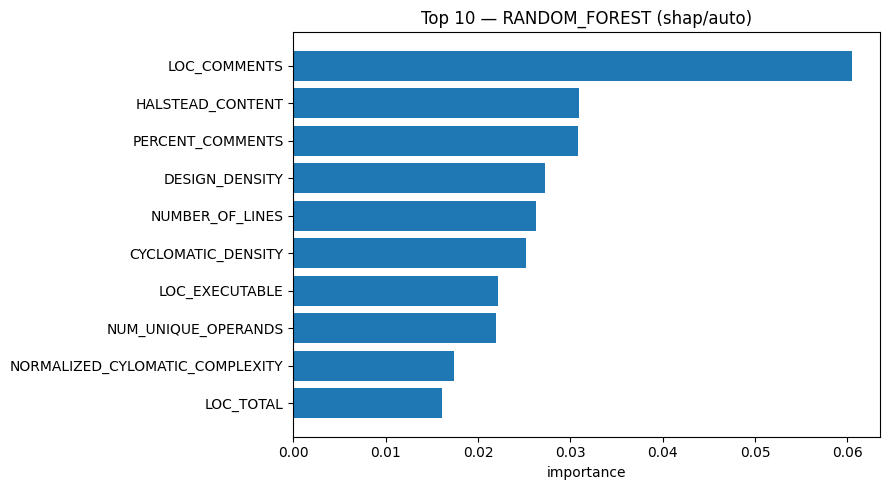

In [13]:
# Example: run LCNN1D with gradient-based importance (adjust as needed)
df_cls, arts, (src_model, imp) = run_pipeline_with_plot(
    model_name="random_forest",
    shap_method="auto",
    importance_source="shap",
    data_path="./../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    protocol="kfold",
    n_splits=5,
    repeats=30,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)

Loaded dataset with header: ./../dataset/CM1.csv
Shape: (327, 35)
Class distribution: {0: 285, 1: 42}
=== Running xnam (importance=shap, shap=auto) ===


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[CACHE] Saved -> ./saved_models/xnam-shap-auto-F1-sig9185adee-p35-seed43.pt


  0%|          | 0/261 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/66 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[CACHE] Saved -> ./saved_models/xnam-shap-auto-F2-sig9185adee-p35-seed44.pt


  0%|          | 0/261 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/66 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[CACHE] Saved -> ./saved_models/xnam-shap-auto-F3-sig9185adee-p35-seed45.pt


  0%|          | 0/262 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/65 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[CACHE] Saved -> ./saved_models/xnam-shap-auto-F4-sig9185adee-p35-seed46.pt


  0%|          | 0/262 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/65 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[CACHE] Saved -> ./saved_models/xnam-shap-auto-F5-sig9185adee-p35-seed47.pt


  0%|          | 0/262 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/65 [00:00<?, ?it/s]

,Model,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex
0,xnam,0.7377,0.3535,0.2673,0.5583,0.9311,0.3998,0.7478,0.8465


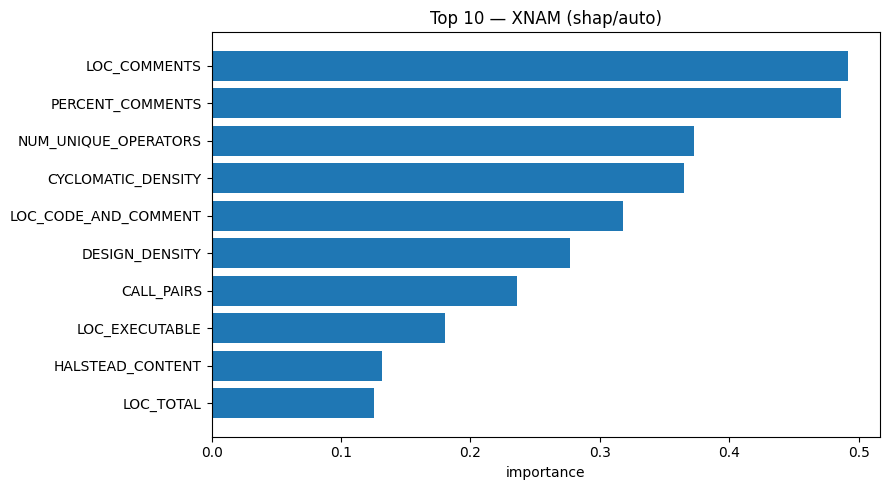

In [14]:
# Example: run LCNN1D with gradient-based importance (adjust as needed)
df_cls, arts, (src_model, imp) = run_pipeline_with_plot(
    model_name="xnam",
    shap_method="auto",
    importance_source="shap",
    data_path="./../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    protocol="kfold",
    n_splits=5,
    repeats=30,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)

Loaded dataset with header: ./../dataset/CM1.csv
Shape: (327, 35)
Class distribution: {0: 285, 1: 42}
=== Running lcnn1d (importance=gradient, shap=auto) ===
[CACHE] Saved -> ./saved_models/lcnn1d-gradient-auto-F1-sig9185adee-p35-seed43.pt
[CACHE] Saved -> ./saved_models/lcnn1d-gradient-auto-F2-sig9185adee-p35-seed44.pt
[CACHE] Saved -> ./saved_models/lcnn1d-gradient-auto-F3-sig9185adee-p35-seed45.pt
[CACHE] Saved -> ./saved_models/lcnn1d-gradient-auto-F4-sig9185adee-p35-seed46.pt
[CACHE] Saved -> ./saved_models/lcnn1d-gradient-auto-F5-sig9185adee-p35-seed47.pt


,Model,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex
0,lcnn1d,0.7272,0.391,0.2991,0.625,0.9799,0.2726,0.7004,0.8255


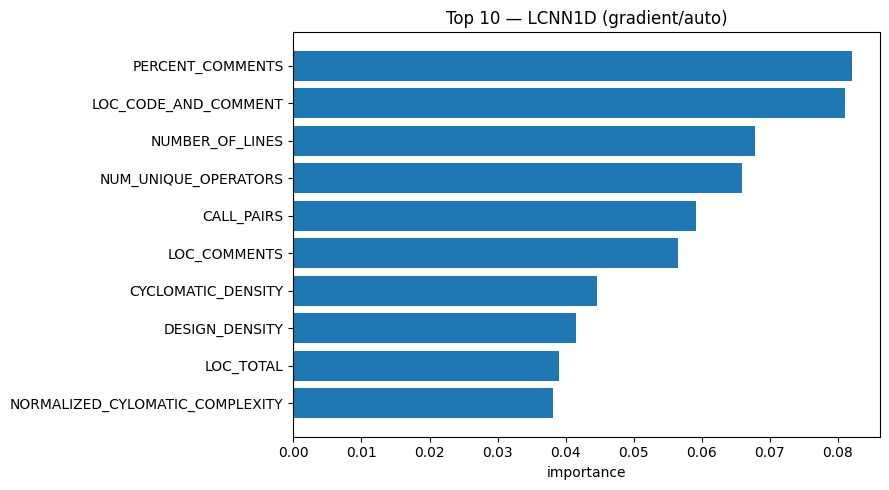

In [15]:
# Example: run LCNN1D with gradient-based importance (adjust as needed)
df_cls, arts, (src_model, imp) = run_pipeline_with_plot(
    model_name="lcnn1d",
    shap_method="auto",
    importance_source="gradient",
    data_path="./../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    protocol="kfold",
    n_splits=5,
    repeats=30,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)

Loaded dataset with header: ./../dataset/CM1.csv
Shape: (327, 35)
Class distribution: {0: 285, 1: 42}
=== Running lcnn2d (importance=gradient, shap=auto) ===
[CACHE] Saved -> ./saved_models/lcnn2d-gradient-auto-F1-sig9185adee-p35-seed43.pt
[CACHE] Saved -> ./saved_models/lcnn2d-gradient-auto-F2-sig9185adee-p35-seed44.pt
[CACHE] Saved -> ./saved_models/lcnn2d-gradient-auto-F3-sig9185adee-p35-seed45.pt
[CACHE] Saved -> ./saved_models/lcnn2d-gradient-auto-F4-sig9185adee-p35-seed46.pt
[CACHE] Saved -> ./saved_models/lcnn2d-gradient-auto-F5-sig9185adee-p35-seed47.pt


,Model,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex
0,lcnn2d,0.7168,0.294,0.2232,0.475,0.9663,0.2825,0.7509,0.8333


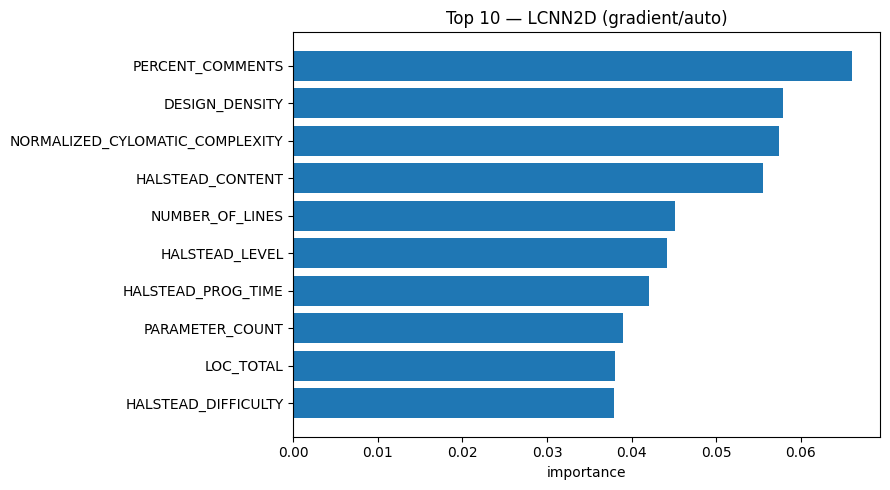

In [16]:
# Example: run LCNN1D with gradient-based importance (adjust as needed)
df_cls, arts, (src_model, imp) = run_pipeline_with_plot(
    model_name="lcnn2d",
    shap_method="auto",
    importance_source="gradient",
    data_path="./../dataset/CM1.csv",
    target_col="Defective",
    top_k=10,
    protocol="kfold",
    n_splits=5,
    repeats=30,
    use_smote=True,
    cfg_overrides=None,
    show_plot=True,
)